## Transfer Learning for Computer Vision

References: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

Runs in [Collab](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/62840b1eece760d5e42593187847261f/transfer_learning_tutorial.ipynb)

**Author**: [Sasank Chilamkurthy](https://chsasank.github.io)

In this tutorial, you will learn how to train a convolutional neural network for image classification using transfer learning. You can read more about the transfer learning at [cs231n notes](https://cs231n.github.io/transfer-learning)

Quoting these notes,

    In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we 
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.



In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion() #interactive mode

## Load Data

[Download data](https://download.pytorch.org/tutorial/hymenoptera_data.zip)

We will use torchvision and torch.utils.data packages for loading data.

The problems we're going to solve today i train model to classify ants and bees. We have about 120 training images eachs generalize for ants and bees. There are 75 validation images for each class. Usually, this is a vary small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonbly well.

This dataset is a very small subset of imagenet.

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images.

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor"""
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std*inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) #pause a bit so that plots are updated

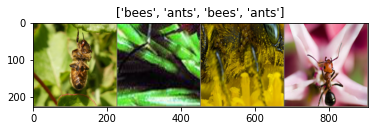

In [4]:
#Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

#make a gird from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

- Scheduling the learning rate
- Saving the best model

In the folowing, parameter `schedule` is an LR scheduler object from `torch.optim.lr_schedulerr`

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'*10)
        
        #Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == ' train':
                model.train() #Set model to training mode
            else :
                model.eval()  #Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            #Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                #zero the parameter gradients
                optimizer.zero_grad()
                
                #forward 
                #track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    #backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                #statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss/dataset_sizes[phase]
            epoch_acc = running_corrects.double()/dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            #deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in: {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))
    
    #load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the convnet

Load a pretrained model and reset final full connected layer

In [10]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
#here the size of each output sample is set to 2.
#Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names))
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

#Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

#Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                      num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7179 Acc: 0.5943
val Loss: 0.6848 Acc: 0.6078

Epoch 1/24
----------
train Loss: 0.6940 Acc: 0.5123
val Loss: 0.6974 Acc: 0.4771

Epoch 2/24
----------
train Loss: 0.6855 Acc: 0.5574
val Loss: 0.6660 Acc: 0.6078

Epoch 3/24
----------
train Loss: 0.6532 Acc: 0.5779
val Loss: 0.6490 Acc: 0.5425

Epoch 4/24
----------
train Loss: 0.6976 Acc: 0.5123
val Loss: 0.7136 Acc: 0.4575

Epoch 5/24
----------
train Loss: 0.6931 Acc: 0.4590
val Loss: 0.6923 Acc: 0.5425

Epoch 6/24
----------
train Loss: 0.6933 Acc: 0.4795
val Loss: 0.6924 Acc: 0.6144

Epoch 7/24
----------
train Loss: 0.6925 Acc: 0.5779
val Loss: 0.6923 Acc: 0.6275

Epoch 8/24
----------
train Loss: 0.6924 Acc: 0.5902
val Loss: 0.6922 Acc: 0.6405

Epoch 9/24
----------
train Loss: 0.6920 Acc: 0.6230
val Loss: 0.6919 Acc: 0.5490

Epoch 10/24
----------
train Loss: 0.6914 Acc: 0.5615
val Loss: 0.6914 Acc: 0.4706

Epoch 11/24
----------
train Loss: 0.6904 Acc: 0.5984
val Loss: 0.6907 Acc: 0.4641

Ep

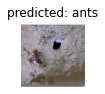

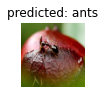

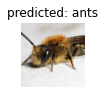

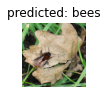

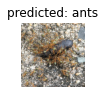

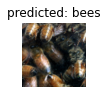

In [12]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.

In [14]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
#parameters of newly constructed modelues have rewuires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

#Observe that only parameters of final layer are being optimized as opposed to before
optim_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

#Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optim_conv, step_size=7, gamma=0.1)

In [15]:
model_conv = train_model(model_conv, criterion, optim_conv,
                        exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.3077 Acc: 0.8607
val Loss: 0.1522 Acc: 0.9608

Epoch 1/24
----------
train Loss: 0.1330 Acc: 0.9549
val Loss: 0.1608 Acc: 0.9608

Epoch 2/24
----------
train Loss: 0.1137 Acc: 0.9590
val Loss: 0.1535 Acc: 0.9608

Epoch 3/24
----------
train Loss: 0.1542 Acc: 0.9303
val Loss: 0.1525 Acc: 0.9608

Epoch 4/24
----------
train Loss: 0.0889 Acc: 0.9631
val Loss: 0.1724 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.1047 Acc: 0.9713
val Loss: 0.1755 Acc: 0.9608

Epoch 6/24
----------
train Loss: 0.1465 Acc: 0.9385
val Loss: 0.1622 Acc: 0.9608

Epoch 7/24
----------
train Loss: 0.0936 Acc: 0.9549
val Loss: 0.1587 Acc: 0.9608

Epoch 8/24
----------
train Loss: 0.0841 Acc: 0.9672
val Loss: 0.1466 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.0751 Acc: 0.9795
val Loss: 0.1488 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.0971 Acc: 0.9672
val Loss: 0.1589 Acc: 0.9608

Epoch 11/24
----------
train Loss: 0.0790 Acc: 0.9631
val Loss: 0.1510 Acc: 0.9542

Ep

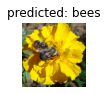

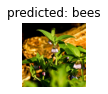

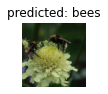

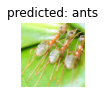

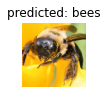

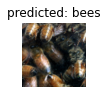

In [17]:
visualize_model(model_conv)